In [75]:
# JAX-based Slime Mold Foraging Simulation (Stage 1)

import jax
import jax.numpy as jnp
from jax import random, lax
import numpy as np
from noise_custom import Perlin, perlin_multi_octave
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree

In [76]:
# --- Parameters ---
substrate_size = 800
n_agents = 50
agent_speed = 1.5
fps = 60
n_frames = 60 * fps  # 60 seconds at 60 fps
force_c = 10.0
nuclei_sampling_rate = 1 # 3 frames every second
# randomly generate 8 food sources
n_food_sources = 10
food_sources = jax.random.uniform(random.PRNGKey(0), (n_food_sources, 2), minval=substrate_size*0.1, maxval=substrate_size*0.9)
food_sources = jnp.round(food_sources).astype(jnp.int32)
total_agents = len(food_sources) * n_agents
depletion_threshold = n_agents // 10

In [77]:
# --- Precompute Perlin noise for all agents and timesteps ---
n_frames_noise = jnp.round(1.5*n_frames).astype(jnp.int32)
noise_array = jnp.zeros((n_frames, total_agents, 2))

# generate offset for each agent and dimension
offsets = jax.random.uniform(random.PRNGKey(0), (total_agents, 2), minval=0, maxval=0.5)
offsets = jnp.round(offsets * n_frames).astype(jnp.int32)

for agent in range(total_agents):
    # Generate noise for each agent, with random_start for decorrelation
    p_x = Perlin(seed=agent + 1)
    noise_x_full = jnp.array([perlin_multi_octave(p_x, t / fps + p_x.lowerBound, octaves=4, persistence=0.5, lacunarity=2.0) for t in range(n_frames_noise)])
    p_y = Perlin(seed=2*(agent + 1))
    noise_y_full = jnp.array([perlin_multi_octave(p_y, t / fps + p_y.lowerBound, octaves=4, persistence=0.5, lacunarity=2.0) for t in range(n_frames_noise)])
    # Apply the offset for this agent and dimension
    start_x = int(offsets[agent, 0])
    start_y = int(offsets[agent, 1])
    noise_x = noise_x_full[start_x:start_x + n_frames]
    noise_y = noise_y_full[start_y:start_y + n_frames]

    noise = jnp.stack((noise_x, noise_y), axis=-1)
    noise_array = noise_array.at[:, agent].set(noise)

Noise range: -0.34841844 0.3366199
Noise range: -1.0 1.0


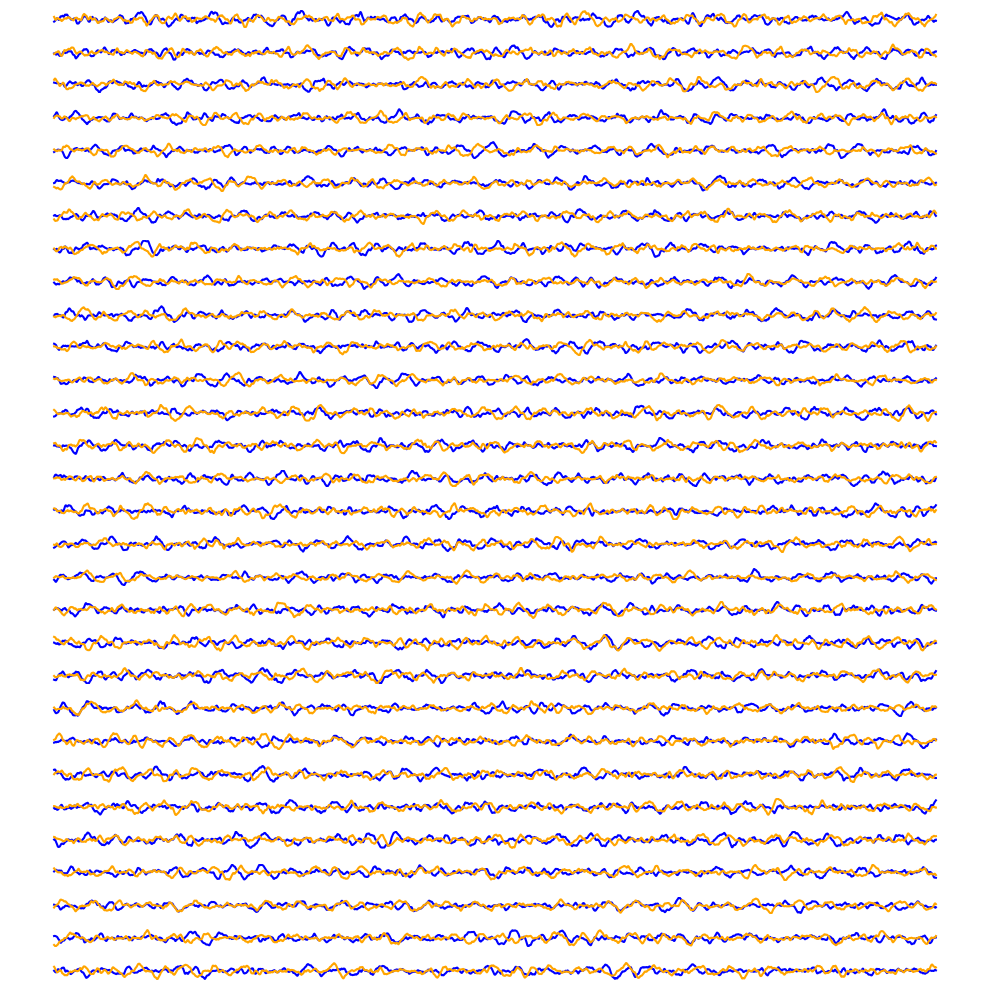

In [78]:
# print the range of the noise values
print("Noise range:", jnp.min(noise_array), jnp.max(noise_array))
# set the range of the noise values to be between -1 and 1
noise_array = (noise_array - jnp.min(noise_array)) / (jnp.max(noise_array) - jnp.min(noise_array)) * 2 - 1
print("Noise range:", jnp.min(noise_array), jnp.max(noise_array))
# Plot the noise for a few agents
fig, axs = plt.subplots(30, 1, figsize=(10, 10), sharex=True)
for i in range(30):
    axs[i].plot(noise_array[:, i, 0], label='X Component', color='blue')
    axs[i].plot(noise_array[:, i, 1], label='Y Component', color='orange')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [79]:
# --- Outer simulation loop in Python ---
positions = [jnp.ones((n_agents, 2)) * substrate_size / 2]  # list of arrays
food_status = jnp.ones(len(food_sources)) # 1 means active, 0 means depleted
food_counts = jnp.zeros(len(food_sources))
all_trails = jnp.zeros((n_frames, total_agents, 2))

for t in range(n_frames):
    # Stack all current agent positions
    pos = jnp.vstack(positions)
    n_current_agents = pos.shape[0]

    # Compute deterministic force from the closest active food source for each agent
    vectors = food_sources[None, :, :] - pos[:, None, :]  # (n_agents, n_food, 2)
    dists = jnp.linalg.norm(vectors, axis=-1) + 1e-6      # (n_agents, n_food)
    # Mask out inactive food sources by setting their distance to a large value
    masked_dists = dists + (1.0 - food_status[None, :]) * 1e9
    closest_idx = jnp.argmin(masked_dists, axis=1) # (n_agents,)

    # Gather the vector and distance to the closest food source for each agent
    closest_vectors = vectors[jnp.arange(pos.shape[0]), closest_idx]  # (n_agents, 2)
    closest_dists = masked_dists[jnp.arange(pos.shape[0]), closest_idx]  # (n_agents,)

    min_dist = 1.0  # Prevent division by very small distances
    safe_dists = jnp.maximum(closest_dists, min_dist)
    force_mag = jnp.sqrt(force_c / safe_dists)
    force_dir = closest_vectors / safe_dists[..., None]
    deterministic = force_dir * force_mag[..., None]  # (n_agents, 2)
    
    # Stochastic force
    stochastic = noise_array[t, :n_current_agents]
    move_vec = deterministic + stochastic
    move_vec /= jnp.linalg.norm(move_vec, axis=1, keepdims=True) + 1e-6  # Normalize to unit length
    # Scale by agent speed
    move_vec = move_vec * agent_speed #/ (jnp.linalg.norm(move_vec, axis=1, keepdims=True) + 1e-6) 
    new_pos = pos + move_vec

    # Check for agents
    reached = jnp.linalg.norm(new_pos[:, None, :] - food_sources[None, :, :], axis=-1) < 5.0
    food_counts = jnp.sum(reached, axis=0)
    # Find which food sources are newly depleted this step
    newly_depleted = (food_status == 1) & (food_counts >= depletion_threshold)
    food_status = food_status * (food_counts < depletion_threshold)

    # For each newly depleted food source, spawn n_agents at its location
    for i, depleted in enumerate(newly_depleted):
        if depleted:
            print(f"Food source {i} depleted at timestep {t//60}.")
            spawn = jnp.tile(food_sources[i], (n_agents, 1)).astype(jnp.float32)
            positions.append(spawn)

    # Save trail for plotting
    if t % (nuclei_sampling_rate) == 0:
        all_trails = all_trails.at[t, :n_current_agents].set(pos[:n_current_agents])

    # Update positions for next step
    positions[:n_current_agents] = new_pos

    # Stop if all food sources are depleted
    if jnp.all(food_status == 0):
        print(f"All food sources depleted. Stop at timestep {t//60}.")
        # get rid of the positions that are zero,zero in all_trails
        all_trails = all_trails[:t]
        all_trails = all_trails[~jnp.all(all_trails == 0, axis=(1, 2))]
        break
    elif t == n_frames - 1:
        print(f"Reached max timesteps. Stop at timestep {t//60}.")
        # get rid of the positions that are zero,zero in all_trails
        all_trails = all_trails[:t]
        all_trails = all_trails[~jnp.all(all_trails == 0, axis=(1, 2))]
        break

Food source 1 depleted at timestep 1.
Food source 3 depleted at timestep 2.
Food source 6 depleted at timestep 3.
Food source 8 depleted at timestep 6.
Food source 7 depleted at timestep 8.
Food source 4 depleted at timestep 8.
Food source 0 depleted at timestep 9.
Food source 5 depleted at timestep 9.
Food source 9 depleted at timestep 11.
Food source 2 depleted at timestep 11.
All food sources depleted. Stop at timestep 11.


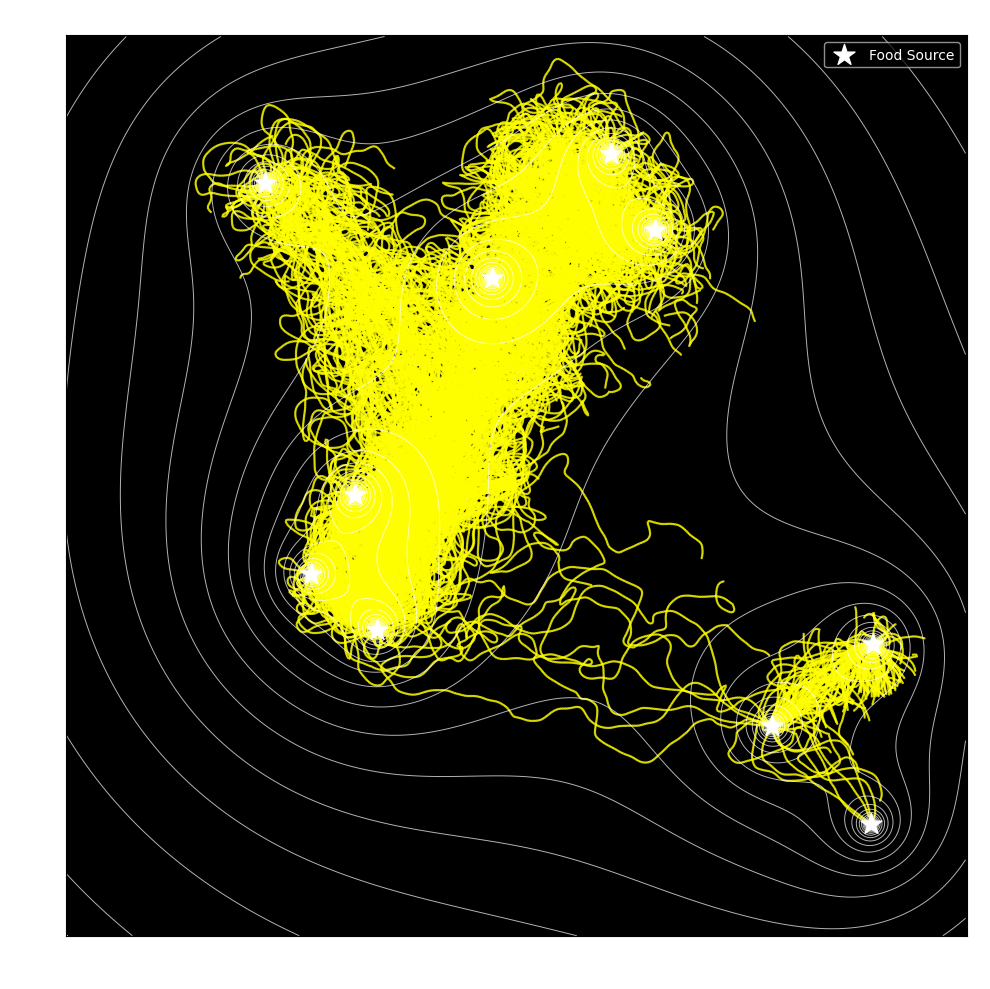

In [80]:
# --- Improved Plot: Slime Mold Foraging Simulation ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Attractive field as filled contours (viridis) and white contour lines
x, y = np.meshgrid(np.arange(substrate_size), np.arange(substrate_size))
attractiveness = np.zeros((substrate_size, substrate_size))
for i in range(len(food_sources)):
    vectors = food_sources[i] - np.dstack((x, y))
    dists = np.linalg.norm(vectors, axis=-1) + 1e-6
    attractiveness += (np.sqrt(force_c / dists))

# Specify contour levels explicitly
levels=np.linspace(0, 5, 50)
# cf = ax.contourf(x, y, attractiveness, levels=levels, cmap='viridis', alpha=0.5)
cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Plot agent trails
ax.scatter(all_trails[:, :, 0].flatten(), all_trails[:, :, 1].flatten(), c='yellow', alpha=0.8, s=3, edgecolors='none')

# Plot food sources as white stars with red edge
ax.scatter(food_sources[:, 0], food_sources[:, 1], c='white', marker='*', s=250, label='Food Source')

# Axis and legend
ax.set_xlim(0, substrate_size)
ax.set_ylim(0, substrate_size)
ax.set_title('Slime Mold Foraging Simulation', color='white', fontsize=16)
ax.set_xlabel('X Position', color='white')
ax.set_ylabel('Y Position', color='white')
ax.tick_params(colors='white')
legend = ax.legend(facecolor='black', framealpha=0.7, loc='upper right')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

In [81]:
import imageio
import os

def create_slime_mold_gif(
    all_trails,
    food_sources,
    attractiveness,
    filename='gifs/slime_mold_simulation.gif',
    fps=10,
    frame_step=10,
    substrate_size=800
):
    """
    Create a GIF showing the growth of all_trails, food sources, and attractiveness contours.
    """

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    images = []
    x, y = np.meshgrid(np.arange(substrate_size), np.arange(substrate_size))
    levels = np.linspace(0, 5, 50)

    for t in range(0, all_trails.shape[0], frame_step):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_facecolor('black')

        # Plot attractiveness contours
        cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

        # Plot agent trails up to current frame
        ax.scatter(
            all_trails[:t, :, 0].flatten(),
            all_trails[:t, :, 1].flatten(),
            c='yellow', alpha=0.3, s=3, edgecolors='none'
        )
        # Highlight current positions
        if t < all_trails.shape[0]:
            ax.scatter(
                all_trails[t+1, :, 0].flatten(),
                all_trails[t+1, :, 1].flatten(),
                c='cyan', alpha=0.8, s=7, edgecolors='none'
            )

        # Plot food sources as white stars
        ax.scatter(food_sources[:, 0], food_sources[:, 1], c='white', marker='*', s=250, label='Food Source')

        ax.set_xlim(0, substrate_size)
        ax.set_ylim(0, substrate_size)
        ax.set_title('Slime Mold Foraging Simulation', color='white', fontsize=16)
        ax.set_xlabel('X Position', color='white')
        ax.set_ylabel('Y Position', color='white')
        ax.tick_params(colors='white')
        legend = ax.legend(facecolor='black', framealpha=0.7, loc='upper right')
        for text in legend.get_texts():
            text.set_color('white')

        plt.tight_layout()
        temp_filename = f"frame_{t}.png"
        plt.savefig(temp_filename)
        plt.close(fig)
        images.append(imageio.imread(temp_filename))
        os.remove(temp_filename)

    imageio.mimsave(filename, images, fps=fps)

In [82]:
# Example usage:
create_slime_mold_gif(all_trails, food_sources, attractiveness, filename='gifs/slime_mold_simulation.gif', fps=fps, frame_step=5, substrate_size=substrate_size)

/var/folders/_t/k7g7kxnn08gbcw98nd8r1qq40000gn/T/ipykernel_11813/2394136303.py:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


In [83]:
# 1. Gather all points: nuclei trail points + food sources
# Flatten all_trails and remove zero rows (unused slots)
nuclea_sampling_rate = 20
all_trails = all_trails[::nuclea_sampling_rate]  # Downsample
points = all_trails.reshape(-1, 2)
points = points[~np.all(points == 0, axis=1)]  # Remove zero points

# Add food sources (convert to numpy if needed)
food_points = np.array(food_sources)
all_points = np.vstack([points, food_points])

# 2. Build KDTree for fast neighbor search
tree = cKDTree(all_points)

# 3. For each point, find its pm=10 nearest neighbors (excluding itself)
pm = 10
dists, idxs = tree.query(all_points, k=pm+1)  # +1 because first neighbor is itself

# 4. Build the proximity graph
G = nx.Graph()

# idxs: shape (N, pm+1), where idxs[i, 0] == i (self), idxs[i, 1:] are neighbors
src = np.repeat(np.arange(idxs.shape[0]), idxs.shape[1] - 1)
dst = idxs[:, 1:].reshape(-1) 
edges = np.stack([src, dst], axis=1) # shape (N*(pm-1), 2)

# Compute edge weights (Euclidean distances)
diffs = all_points[edges[:, 0]] - all_points[edges[:, 1]]
weights = np.linalg.norm(diffs, axis=1)

# Add all edges at once to the graph
G.add_weighted_edges_from([(int(i), int(j), float(w)) for (i, j), w in zip(edges, weights)])

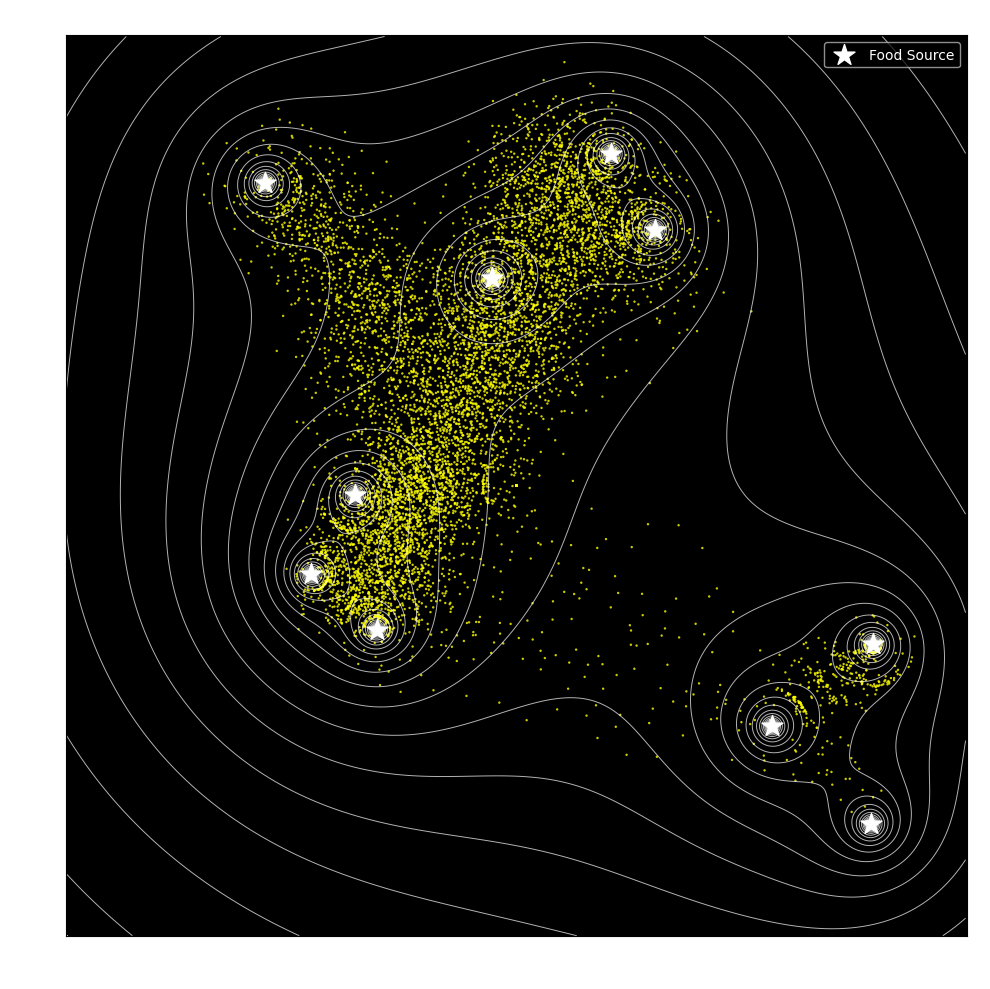

In [84]:
# --- Improved Plot: Slime Mold Foraging Simulation ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Attractive field as filled contours (viridis) and white contour lines
x, y = np.meshgrid(np.arange(substrate_size), np.arange(substrate_size))
attractiveness = np.zeros((substrate_size, substrate_size))
for i in range(len(food_sources)):
    vectors = food_sources[i] - np.dstack((x, y))
    dists = np.linalg.norm(vectors, axis=-1) + 1e-6
    attractiveness += (np.sqrt(force_c / dists))

# Specify contour levels explicitly
levels=np.linspace(0, 5, 50)
# cf = ax.contourf(x, y, attractiveness, levels=levels, cmap='viridis', alpha=0.5)
cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Plot agent trails
ax.scatter(all_trails[:, :, 0].flatten(), all_trails[:, :, 1].flatten(), c='yellow', alpha=0.8, s=3, edgecolors='none')

# Plot food sources as white stars with red edge
ax.scatter(food_sources[:, 0], food_sources[:, 1], c='white', marker='*', s=250, label='Food Source')

# Axis and legend
ax.set_xlim(0, substrate_size)
ax.set_ylim(0, substrate_size)
ax.set_title('Slime Mold Foraging Simulation', color='white', fontsize=16)
ax.set_xlabel('X Position', color='white')
ax.set_ylabel('Y Position', color='white')
ax.tick_params(colors='white')
legend = ax.legend(facecolor='black', framealpha=0.7, loc='upper right')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.savefig('slime_mold_nuclei.png', dpi=300)
plt.show()

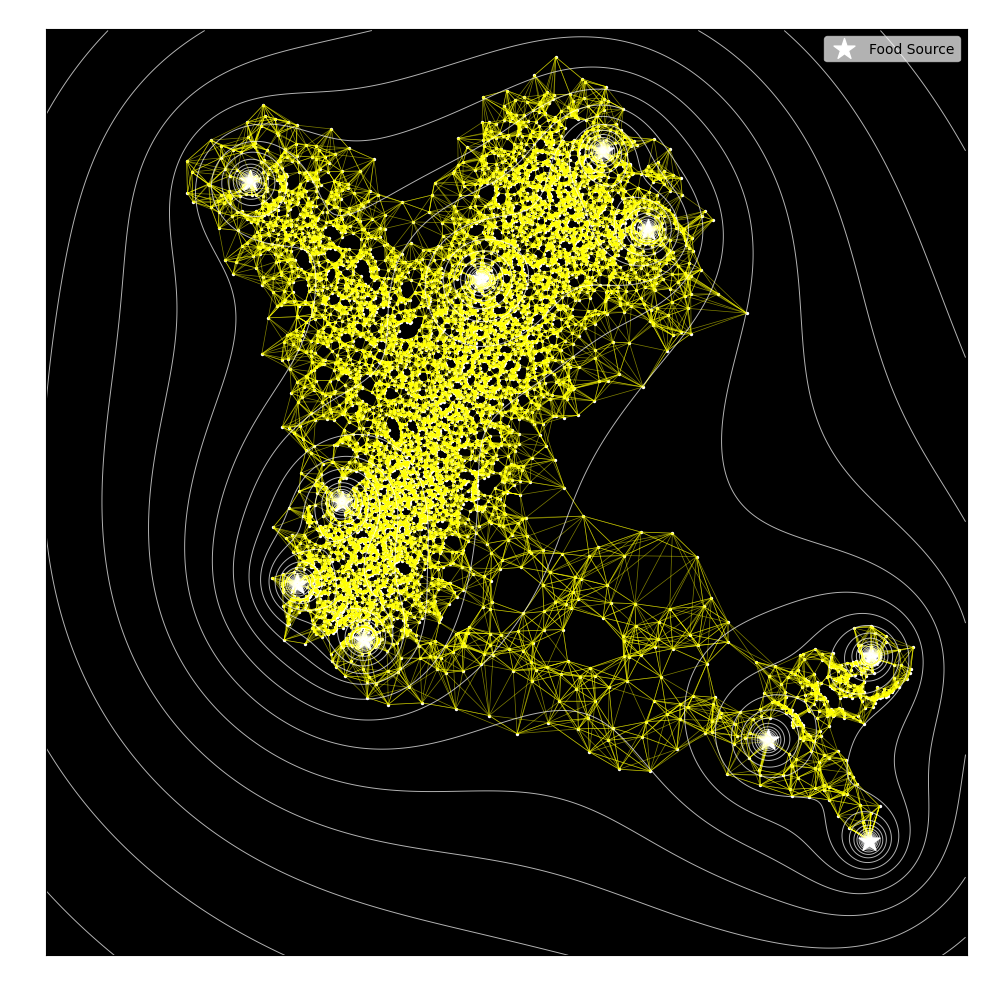

In [85]:
from matplotlib.collections import LineCollection

# Prepare edge segments for LineCollection
edge_segments = np.stack([
    np.stack([all_points[edges[:, 0]], all_points[edges[:, 1]]], axis=1)
], axis=0).reshape(-1, 2, 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Draw all edges at once
lc = LineCollection(edge_segments, colors='yellow', linewidths=0.5, alpha=0.5)
ax.add_collection(lc)

cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Draw points
ax.scatter(points[:, 0], points[:, 1], c='white', s=2)
ax.scatter(food_points[:, 0], food_points[:, 1], c='white', marker='*', s=250, label='Food Source')

ax.set_xlim(0, substrate_size)
ax.set_ylim(0, substrate_size)
ax.set_title('10-Nearest Neighbor Proximity Mesh', color='white')
ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
ax.tick_params(colors='white')
plt.tight_layout()
plt.savefig('slime_mold_proximity_mesh.png', dpi=300)
plt.show()

In [90]:
from scipy.spatial import distance_matrix
from itertools import combinations

# --- Proximity coefficient ---
p = 3 # Set this to your desired number of closest neighbors

# Indices of food sources in all_points (they are last in the array)
food_indices = np.arange(all_points.shape[0] - len(food_points), all_points.shape[0])

# Compute pairwise distances between food sources
food_coords = all_points[food_indices]
food_dmat = distance_matrix(food_coords, food_coords)

# For each food source, get indices of its p closest food source neighbors (excluding self)
np.fill_diagonal(food_dmat, np.inf)
closest_neighbors = np.argsort(food_dmat, axis=1)[:, :p]

# Build set of unique food source pairs to connect (undirected)
food_pairs = set()
for i, nbrs in enumerate(closest_neighbors):
    for j in nbrs:
        # Convert local indices to global indices in all_points
        a, b = food_indices[i], food_indices[j]
        food_pairs.add(tuple(sorted((a, b))))

# --- Build refined network using only mesh edges ---
edge_set = set()
for a, b in food_pairs:
    try:
        path = nx.shortest_path(G, source=a, target=b, weight='weight')
        edge_set.update((min(path[k], path[k+1]), max(path[k], path[k+1])) for k in range(len(path)-1))
    except nx.NetworkXNoPath:
        continue

# Convert edge_set to array for vectorized plotting
refined_edges = np.array(list(edge_set))
refined_segments = np.stack([all_points[refined_edges[:, 0]], all_points[refined_edges[:, 1]]], axis=1)

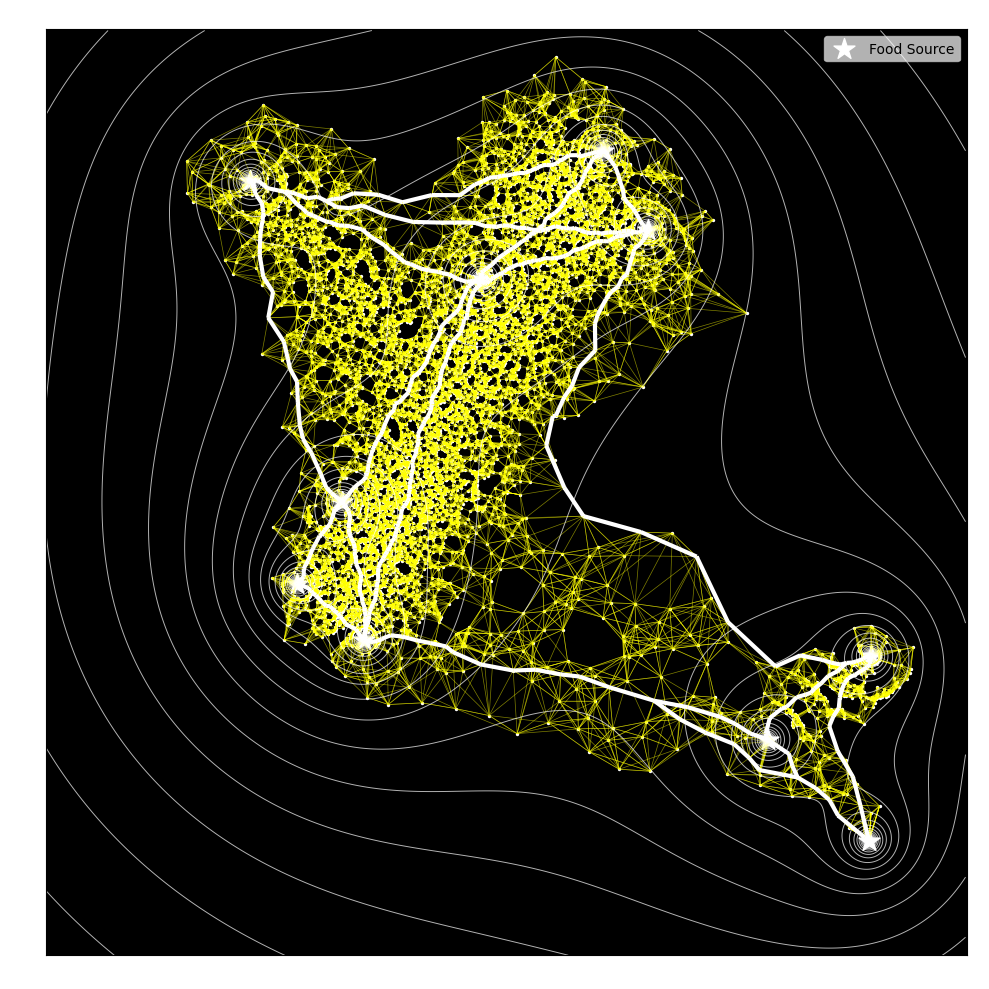

In [91]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')

# Optionally, overlay the mesh in the background (faint)
lc_mesh = LineCollection(edge_segments, colors='yellow', linewidth=0.5, alpha=0.5)
ax.add_collection(lc_mesh)

# Draw refined network edges
lc = LineCollection(refined_segments, colors='white', linewidths=3)
ax.add_collection(lc)

cl = ax.contour(x, y, attractiveness, levels=levels, colors='white', linewidths=0.7, alpha=0.7)

# Draw points
ax.scatter(points[:, 0], points[:, 1], c='white', s=2)
ax.scatter(food_points[:, 0], food_points[:, 1], c='white', marker='*', s=250, label='Food Source')

ax.set_xlim(0, substrate_size)
ax.set_ylim(0, substrate_size)
ax.set_title('Refined Shortest-Walk Network (Stage 2)', color='white')
ax.legend(facecolor='white', framealpha=0.7, loc='upper right')
ax.tick_params(colors='white')
plt.tight_layout()
plt.savefig('slime_mold_refined_network.png', dpi=300)
plt.show()